In [12]:
import AAnet
import network
import numpy as np
import AAtools
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import tensorflow as tf
import time
import pickle
from sklearn.decomposition import PCA
from PCHA import PCHA
from scipy.spatial import procrustes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# params fake data
n = 2000
nat = 3
ndim = 100

In [132]:
# params AAnet
num_at = nat
noise_z_std = 0.05
z_dim = [100,100,100]
#z_dim = [] # linear AA
#act_out = tf.nn.tanh
act_out = None # linear last layer
input_dim = ndim

In [149]:
# network
enc_net = network.Encoder(num_at=num_at, z_dim=z_dim)
dec_net = network.Decoder(x_dim=input_dim, noise_z_std=noise_z_std, z_dim=z_dim, act_out=act_out)
model = AAnet.AAnet(enc_net, dec_net)

In [150]:
# fake data
z = np.random.uniform(size=[n,nat])
z = np.log(z)
z = z / np.sum(z, axis=1, keepdims=True)
at = np.random.uniform(size=[nat,ndim])

In [151]:
exp_vec = np.linspace(1, 0.25, 10)
i = 0
mse_vec_aanet = []
mse_vec_pcha = []
at_list_aanet = []
at_list_pcha = []
for exp_val in exp_vec:
    print('i = %d, exp_val = %f' % (i,exp_val))
    z_concave = z**exp_val
    data = z_concave @ at
    # AAnet
    model.train(data, batch_size=128, num_batches=2000)
    AAnet_at = model.get_ats_x()
    _,_,MSE_AAnet = procrustes(AAnet_at.T, at.T)
    at_list_aanet.append(AAnet_at)
    print('MSE AAnet = %f' % MSE_AAnet)
    mse_vec_aanet.append(MSE_AAnet)
    # PCHA
    XC, _, _, _, _ = PCHA(data.T, noc=nat)
    _,_,MSE_PCHA = procrustes(XC, at.T)
    print('MSE PCHA = %f' % MSE_PCHA)
    at_list_pcha.append(XC.T)
    mse_vec_pcha.append(MSE_PCHA)
    i = i + 1

i = 0, exp_val = 1.000000
Iter [       0] Time [0.2671] loss [0.2784]
Iter [     500] Time [1.5609] loss [0.0004]
Iter [    1000] Time [2.8265] loss [0.0005]
Iter [    1500] Time [4.0379] loss [0.0004]
Iter [    1999] Time [5.6311] loss [0.0003]
done.
MSE AAnet = 0.004383
MSE PCHA = 0.000048
i = 1, exp_val = 0.916667
Iter [       0] Time [0.0041] loss [0.0029]
Iter [     500] Time [1.2223] loss [0.0008]
Iter [    1000] Time [2.4504] loss [0.0004]
Iter [    1500] Time [3.7055] loss [0.0001]
Iter [    1999] Time [4.9902] loss [0.0003]
done.
MSE AAnet = 0.008130
MSE PCHA = 0.022869
i = 2, exp_val = 0.833333
Iter [       0] Time [0.0045] loss [0.0008]
Iter [     500] Time [1.3152] loss [0.0001]
Iter [    1000] Time [2.5629] loss [0.0001]
Iter [    1500] Time [3.7500] loss [0.0001]
Iter [    1999] Time [4.9326] loss [0.0001]
done.
MSE AAnet = 0.004733
MSE PCHA = 0.060470
i = 3, exp_val = 0.750000
Iter [       0] Time [0.0048] loss [0.0007]
Iter [     500] Time [1.2426] loss [0.0002]
Iter [ 

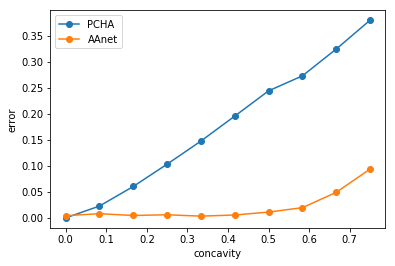

In [152]:
plt.plot(1-exp_vec, mse_vec_pcha, label='PCHA', marker='o')
plt.plot(1-exp_vec, mse_vec_aanet, label='AAnet', marker='o')
plt.xlabel('concavity')
plt.ylabel('error')
plt.legend()
plt.show()

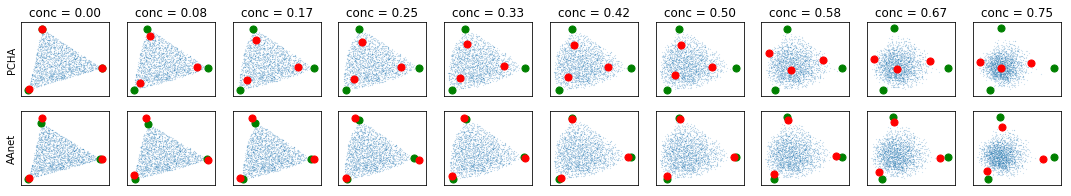

In [153]:
at_array_pcha = np.asarray(at_list_pcha)
at_array_aanet = np.asarray(at_list_aanet)
pca = PCA(n_components=2)
plt.figure(figsize=(30,3))
Y_pca = pca.fit_transform(z @ at)
Y_pca_at = pca.transform(at)
for i in range(len(exp_vec)):
    exp_val = exp_vec[i]
    z_concave = z**exp_val
    data = z_concave @ at
    AT_curr_pcha = at_array_pcha[i,:,:]
    AT_curr_aanet = at_array_aanet[i,:,:]
    Y_pca_data = pca.transform(data)
    Y_pca_pcha = pca.transform(AT_curr_pcha)
    Y_pca_aanet = pca.transform(AT_curr_aanet)
    # plot PCHA
    plt.subplot(2,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Y_pca_data[:,0], Y_pca_data[:,1], s=.01, alpha=0.75)
    plt.scatter(Y_pca_at[:,0], Y_pca_at[:,1], s=50, c='g')
    plt.scatter(Y_pca_pcha[:,0], Y_pca_pcha[:,1], s=50, c='r')
    if i==0:
        plt.ylabel('PCHA')
    plt.title('conc = %1.2f' % (1-exp_val))
    # plot AAnet
    plt.subplot(2,16,i+1+16)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Y_pca_data[:,0], Y_pca_data[:,1], s=.01, alpha=0.75)
    plt.scatter(Y_pca_at[:,0], Y_pca_at[:,1], s=50, c='g')
    plt.scatter(Y_pca_aanet[:,0], Y_pca_aanet[:,1], s=50, c='r')
    if i==0:
        plt.ylabel('AAnet')
plt.show()

In [158]:
# 2
exp_vec = np.linspace(1, 3, 10)
i = 0
mse_vec_aanet = []
mse_vec_pcha = []
at_list_aanet = []
at_list_pcha = []
for exp_val in exp_vec:
    print('i = %d, exp_val = %f' % (i,exp_val))
    z_concave = z**exp_val
    data = z_concave @ at
    # AAnet
    model.train(data, batch_size=128, num_batches=2000)
    AAnet_at = model.get_ats_x()
    _,_,MSE_AAnet = procrustes(AAnet_at.T, at.T)
    at_list_aanet.append(AAnet_at)
    print('MSE AAnet = %f' % MSE_AAnet)
    mse_vec_aanet.append(MSE_AAnet)
    # PCHA
    XC, _, _, _, _ = PCHA(data.T, noc=nat)
    _,_,MSE_PCHA = procrustes(XC, at.T)
    print('MSE PCHA = %f' % MSE_PCHA)
    at_list_pcha.append(XC.T)
    mse_vec_pcha.append(MSE_PCHA)
    i = i + 1

i = 0, exp_val = 1.000000
Iter [       0] Time [0.0053] loss [0.0521]
Iter [     500] Time [1.2536] loss [0.0001]
Iter [    1000] Time [2.5097] loss [0.0004]
Iter [    1500] Time [3.7454] loss [0.0003]
Iter [    1999] Time [5.1390] loss [0.0001]
done.
MSE AAnet = 0.005999
MSE PCHA = 0.000048
i = 1, exp_val = 1.222222
Iter [       0] Time [0.0042] loss [0.0018]
Iter [     500] Time [1.2685] loss [0.0001]
Iter [    1000] Time [2.4804] loss [0.0000]
Iter [    1500] Time [3.6658] loss [0.0001]
Iter [    1999] Time [4.9584] loss [0.0001]
done.
MSE AAnet = 0.002149
MSE PCHA = 0.022923
i = 2, exp_val = 1.444444
Iter [       0] Time [0.0044] loss [0.0025]
Iter [     500] Time [1.2777] loss [0.0002]
Iter [    1000] Time [2.6664] loss [0.0001]
Iter [    1500] Time [4.0693] loss [0.0002]
Iter [    1999] Time [5.2964] loss [0.0001]
done.
MSE AAnet = 0.005881
MSE PCHA = 0.020566
i = 3, exp_val = 1.666667
Iter [       0] Time [0.0042] loss [0.0017]
Iter [     500] Time [1.1878] loss [0.0001]
Iter [ 

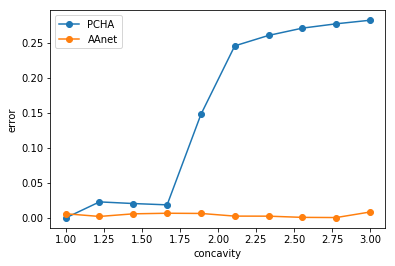

In [159]:
plt.plot(exp_vec, mse_vec_pcha, label='PCHA', marker='o')
plt.plot(exp_vec, mse_vec_aanet, label='AAnet', marker='o')
plt.xlabel('concavity')
plt.ylabel('error')
plt.legend()
plt.show()

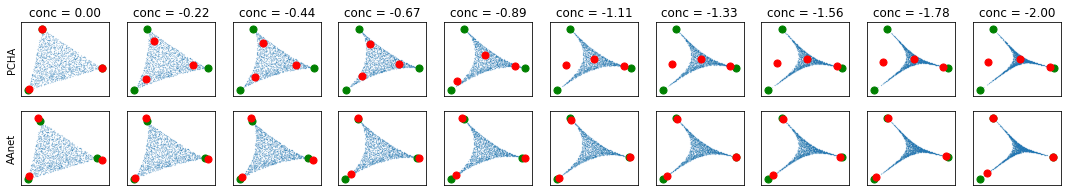

In [160]:
at_array_pcha = np.asarray(at_list_pcha)
at_array_aanet = np.asarray(at_list_aanet)
pca = PCA(n_components=2)
plt.figure(figsize=(30,3))
Y_pca = pca.fit_transform(z @ at)
Y_pca_at = pca.transform(at)
for i in range(len(exp_vec)):
    exp_val = exp_vec[i]
    z_concave = z**exp_val
    data = z_concave @ at
    AT_curr_pcha = at_array_pcha[i,:,:]
    AT_curr_aanet = at_array_aanet[i,:,:]
    Y_pca_data = pca.transform(data)
    Y_pca_pcha = pca.transform(AT_curr_pcha)
    Y_pca_aanet = pca.transform(AT_curr_aanet)
    # plot PCHA
    plt.subplot(2,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Y_pca_data[:,0], Y_pca_data[:,1], s=.01, alpha=0.75)
    plt.scatter(Y_pca_at[:,0], Y_pca_at[:,1], s=50, c='g')
    plt.scatter(Y_pca_pcha[:,0], Y_pca_pcha[:,1], s=50, c='r')
    if i==0:
        plt.ylabel('PCHA')
    plt.title('conc = %1.2f' % (1-exp_val))
    # plot AAnet
    plt.subplot(2,16,i+1+16)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Y_pca_data[:,0], Y_pca_data[:,1], s=.01, alpha=0.75)
    plt.scatter(Y_pca_at[:,0], Y_pca_at[:,1], s=50, c='g')
    plt.scatter(Y_pca_aanet[:,0], Y_pca_aanet[:,1], s=50, c='r')
    if i==0:
        plt.ylabel('AAnet')
plt.show()